In [9]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from sklearn.mixture import GaussianMixture

from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy import optimize
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread

In [43]:
def load_data(path_num,path_all = False):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    if path_all:
        path = path_all
    else:
        path = f'registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder


def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']


def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -ncc(y,warped)


def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())

def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

In [5]:
# pics_without_line = np.array(tiffread('patrice_11_19_2024_timelapse/scan11/stack.tif')).astype(np.float32)

path = 'scan19/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
    # pics_without_line.append(aa.copy())

# pics_without_line = np.array(pics_without_line)
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 316.44it/s]


# Y-Motion

In [6]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2][:,:50],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30

mid = (np.argmax(np.sum(pics_without_line[0][:n//2],axis=1)) + pics_without_line[0].shape[0])//2
mid

933

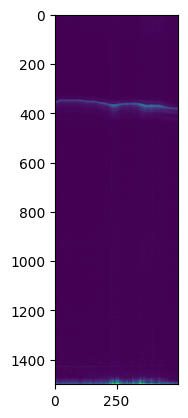

In [7]:
plt.imshow(pics_without_line.transpose(2,1,0)[100])

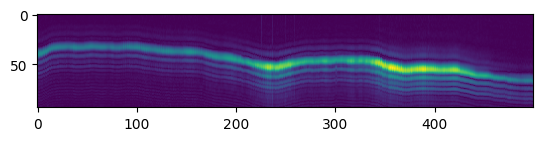

In [8]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

In [9]:
tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 500/500 [00:06<00:00, 77.40it/s]


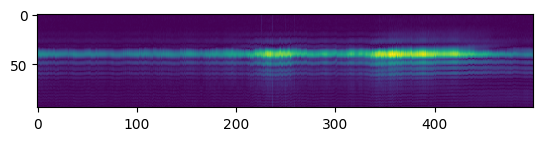

In [10]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

In [11]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30

mid = (np.argmax(np.sum(pics_without_line[0][:n//2],axis=1)) + pics_without_line[0].shape[0])//2
mid

933

In [12]:
def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

def div3(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = phase(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = phase_join_chunks(data[:i],data[i:i+3])
    return data

def phase(data,dis=False):
    n = data.shape[0]//2
    for i in range(data.shape[0]):
        coords = phase_cross_correlation((data[n][UP:DOWN][:,:50])
                                        ,(data[i][UP:DOWN][:,:50])
                                        ,normalization=None,upsample_factor=20)[0]
        data[i] = scp.shift(data[i],shift = (coords[0],0),mode='constant',order=3)
    return data

def phase_join_chunks(first,second):
    coords = phase_cross_correlation((first[-1][UP:DOWN][:,:50])
                                    ,(second[0][UP:DOWN][:,:50])
                                    ,normalization=None,upsample_factor=20)[0]
    for i in range(len(second)):
        second[i] = scp.shift(second[i],shift = (coords[0],0),mode='constant',order=3)
    return second


def div3_reg_optz(data):
    for i in tqdm(range(0,data.shape[0],3)):
        data[i:i+3] = man_reg(data[i:i+3])

    for i in tqdm(range(3,data.shape[0],3)):
        data[i:i+3] = man_join_chunks(data[:i],data[i:i+3])
    return data    

def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)
    # return mse(y,warped)

def upsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_expand(temp_data,upscale=n,mode='constant', cval=0,order=3)
    return temp_data

def downsamp(data,n):
    temp_data = data.copy()
    temp_data = pyramid_reduce(temp_data,downscale=n,mode='constant', cval=0,order=3)
    return temp_data

def samp(data,n):
    if n>1:
        return upsamp(data,n)
    if n<1:
        return downsamp(data,np.abs(math.log(n,2)*2))
    if n==1:
        return data

def man_reg(data):
    n = data.shape[0]//2
    # get_masks = cell_extract(data[1],4)
    for i in range(data.shape[0]):
        tform2 = AffineTransform(translation=(0,0))
        if i!=n:
            # best_mask = compare_masks(get_masks,data[n],data[i])
            temp_i_data = data[i].copy()
            for pyr in [2,2,2,4,4]:
                move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (samp((temp_i_data[220:320,100:200]),pyr)
                                ,samp((data[n][220:320,100:200]),pyr)))['x'])/pyr
                temp_transform = AffineTransform(translation=(0,move[0]))
                temp_i_data = warp(temp_i_data, temp_transform,order=3)
                tform2 = np.dot(tform2,temp_transform)
                # print('iter',pyr,mse(data[i], warp(data[i], tform2,order=3)))
            tform2 = AffineTransform(matrix = tform2)
            data[i] = warp(data[i], tform2,order=3)
            # print('done')
    return data

def man_join_chunks(first,second):
    # get_masks = cell_extract(first[-1],4)
    # best_mask = compare_masks(get_masks,first[-1],second[0])
    tform3 = AffineTransform(translation=(0,0))
    temp = second[0].copy()
    for pyr in [2]*3:
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0),
                    args = (samp((temp[220:320,100:200]),pyr)
                            ,samp((first[-1][220:320,100:200]),pyr)))['x'])/pyr
        temp_transform = AffineTransform(translation=(0,move[0]))
        temp = warp(temp, temp_transform,order=3)
        tform3 = np.dot(tform3,temp_transform)
    tform3 = AffineTransform(matrix = tform3)
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3)
    return second

In [13]:
# pics_without_line[:,:mid] = div3(pics_without_line[:,:mid])

In [14]:
# n = pics_without_line.shape[1]
# nn = []
# for i in range(pics_without_line.shape[0]):
#     nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

# plt.plot(nn)

In [15]:
np.var(nn)

10.804336

In [16]:
n = pics_without_line.shape[1]
nn = []
for i in range(pics_without_line.shape[0]):
    nn.append(np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)))

UP, DOWN = np.min(nn)-30,np.max(nn)+30

In [ ]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)


def ants_all_trans(data):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # tff = AffineTransform(translation=(0,0))
        # PHASE
        coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:50])
                                        ,min_max(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=20)[0]
        # temp_img = scp.shift(temp_img,shift = (coords[0],0),mode='constant',order=3)
        if np.abs(coords[0])<=2:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        for _ in range(5):
            # move = optimize.dual_annealing(mse_fun_tran, bounds = ([[-100,100]])
            #                             ,args = (data[i][UP:DOWN][:,:50],temp_manual[:,:50]))['x']
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (data[i][UP:DOWN][:,:50]
                                ,temp_manual[:,:50]))['x']
            temp_transform = AffineTransform(translation=(0,move[0]))
            temp_manual = warp(temp_manual, temp_transform,order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
        if np.abs(np.array(temp_tform_manual)[1,2])<=2:
            temp_img = warp(temp_img,temp_tform_manual,order=3)
            # tff = temp_tform_manual
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

        # # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=2:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     # ar = np.vstack((mat['AffineTransform_float_2_2'].reshape(2,3,order='F'),[0,0,1]))
        #     # ar[0,2],ar[1,2] = ar[1,2],ar[0,2]
        #     # tff = AffineTransform(matrix = ar)
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all

In [21]:
tr_all = ants_all_trans(pics_without_line)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

tr_all:   2%|▏         | 8/499 [00:16<17:14,  2.11s/it]


KeyboardInterrupt: 

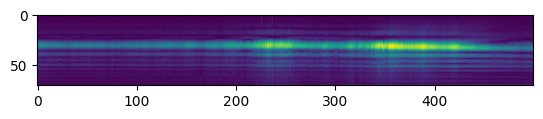

In [27]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

# X-motion

In [28]:
gg = pics_without_line.copy()
UP,DOWN

(327, 398)

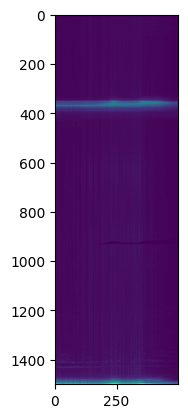

In [29]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [30]:
test = np.max(pics_without_line.transpose(2,1,0),axis=0)

In [40]:
bright_point = np.argmax(np.sum(test[:mid],axis=1))

nn = []
for i in range(gg.shape[0]):
    nn.append(np.argmax(np.sum(gg[i][bright_point+30:mid],axis=1)))

minn,maxx = np.min(nn),np.max(nn)

if np.abs(minn-maxx)<=100:
    maxx = minn+100

UP,DOWN = minn+bright_point+30, maxx+bright_point+30

# dense_point = np.argmax(np.max(test[bright_point+30:bright_point+330],axis=1))+bright_point+30
# bot_mirror = dense_point-bright_point-30
mir_UP,mir_DOWN = test.shape[0]-maxx-80, test.shape[0]-minn-80
UP,DOWN ,mir_UP,mir_DOWN

(399, 499, 1320, 1420)

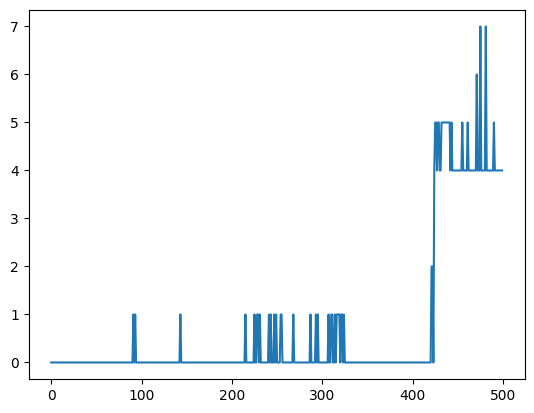

In [41]:
plt.plot(nn)

In [42]:
bright_point

369

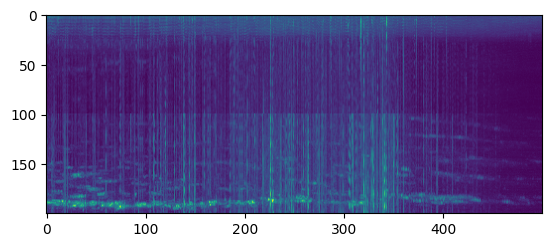

In [45]:
plt.imshow(test[np.r_[UP:DOWN,mir_UP:mir_DOWN]])

In [46]:
transforms_all = np.tile(np.eye(3),(500,1,1))

for i in tqdm(range(gg.shape[0]-1)):
    # tff = AffineTransform(translation=(0,0))
    mat = scipy.io.loadmat(ants_reg_mapping(gg[i][np.r_[UP:DOWN,mir_UP:mir_DOWN]],gg[i+1][np.r_[UP:DOWN,mir_UP:mir_DOWN]])[0])
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

# for i in tqdm(range(gg.shape[0]-1)):
#     # tff = AffineTransform(translation=(0,0))
#     mat = scipy.io.loadmat(ants_reg_mapping(gg[i][1000:1100],gg[i+1][1000:1100])[0])
#     tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

#     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

100%|██████████| 499/499 [01:55<00:00,  4.33it/s]


In [47]:
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)

100%|██████████| 500/500 [00:10<00:00, 48.22it/s]


In [2]:
plt.imshow(gg.transpose(2,1,0)[100])

NameError: name 'plt' is not defined

In [49]:
# os.mkdir('registered/scan12/')
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite('registered/test/'+f'frame_test{i}.PNG',(min_max(j)*(2**8)).astype(np.uint8))

500it [00:03, 153.75it/s]


In [1085]:
# os.mkdir('registered/scan23/')
# for i,j in tqdm(enumerate(gg)):
#     cv2.imwrite('registered/scan23/'+f'frame_test{i}.PNG',(min_max(j)*(2**16)).astype(np.uint16))

500it [00:06, 78.78it/s]


# Inter-Volume

In [11]:
all_reg = natsorted(list(set(os.listdir('registered/'))-set(['test'])))

In [12]:
datas = {}
for paths in all_reg:
    print(f'Loading data: {paths}')
    datas[paths] = load_data(paths)

Loading data: scan11
Loading data: scan12
Loading data: scan13
Loading data: scan14
Loading data: scan15
Loading data: scan16
Loading data: scan17
Loading data: scan18
Loading data: scan19
Loading data: scan20
Loading data: scan21
Loading data: scan22
Loading data: scan23


In [ ]:
datas.keys()

dict_keys(['scan11', 'scan12', 'scan13', 'scan14', 'scan15', 'scan16', 'scan17', 'scan18', 'scan19', 'scan20', 'scan21', 'scan22', 'scan23'])

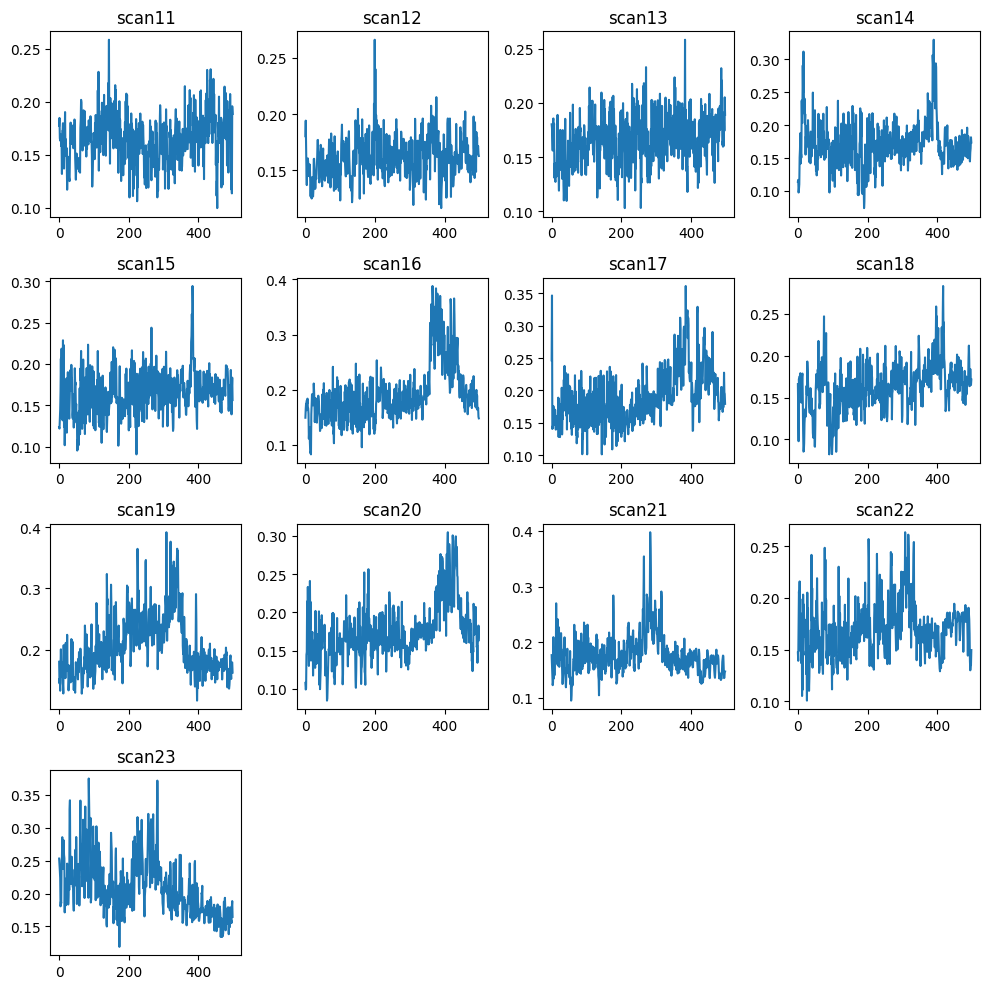

In [41]:
grid_size = int(np.ceil(np.sqrt(len(all_reg))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i,dt in enumerate(all_reg):
    errs = []
    for j in range(datas[dt].shape[0]-1):
        errs.append(1-ncc(datas[dt][j][-200:-80],datas[dt][j+1][-200:-80]))
    axes[i].plot(errs)
    axes[i].set_title(all_reg[i])

# If the number of images doesn't perfectly fill the grid, hide extra subplots
for i in range(len(all_reg), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# for dt in all_reg:
#     errs = []
#     for i in range(datas[dt].shape[0]-1):
#         errs.append(1-ncc(datas[dt][i][-200:-80],datas[dt][i+1][-200:-80]))
#     plt.title(dt)
#     plt.plot(errs)
#     plt.show()

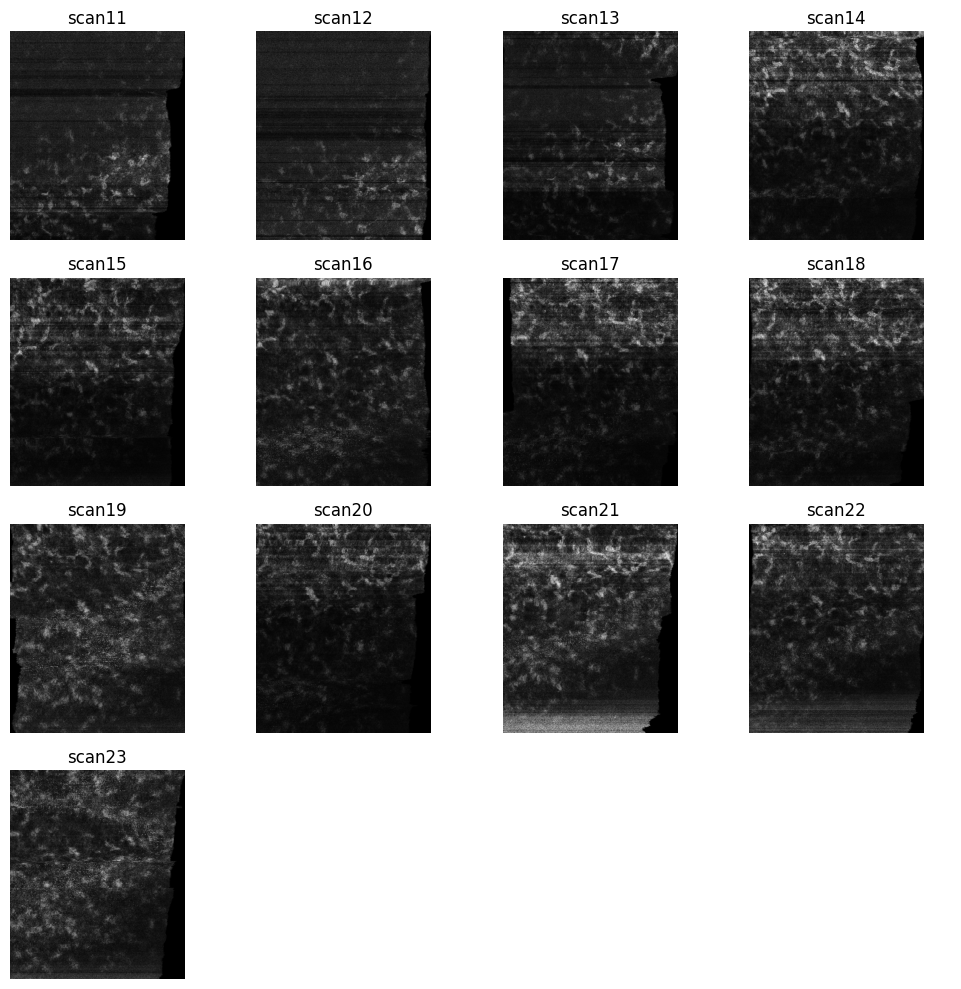

In [44]:
grid_size = int(np.ceil(np.sqrt(len(all_reg))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i,j in enumerate(all_reg):
    axes[i].imshow(equalize_adapthist(min_max(np.mean(datas[j].transpose(1,0,2)[1400:1412],axis=0))), cmap='gray')
    axes[i].set_title(all_reg[i])
    axes[i].axis('off')  # Turn off axis labels

# If the number of images doesn't perfectly fill the grid, hide extra subplots
for i in range(len(all_reg), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [45]:
nerve_images_all = np.empty((len(all_reg),(np.mean(datas[all_reg[0]].transpose(1,0,2)[1428:1436],axis=0)).shape[0]
                                        ,(np.mean(datas[all_reg[0]].transpose(1,0,2)[1428:1436],axis=0)).shape[1])
                                        ,dtype=np.uint8)
for i in range(len(all_reg)):
    nerve_images_all[i] = (min_max(np.mean(datas[all_reg[i]].transpose(1,0,2)[1428:1436],axis=0))*255).astype(np.uint8)

100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


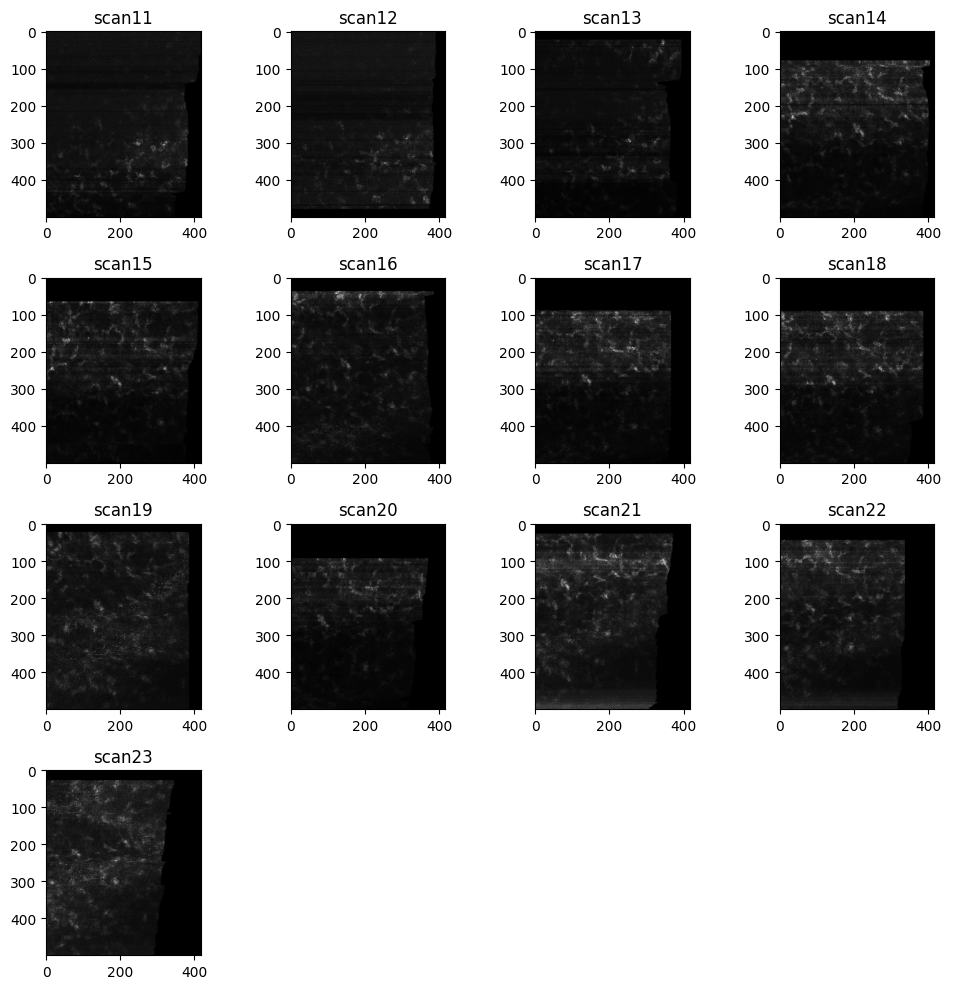

In [282]:
def mse_fun_tran_ncc(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(y, tform,order=3)
    return -ncc(x,warped)


def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 500))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']

reg_nerve_images = np.empty((len(all_reg),(np.mean(datas[all_reg[0]].transpose(1,0,2)[1400:1412],axis=0)).shape[0]
                                        ,(np.mean(datas[all_reg[0]].transpose(1,0,2)[1400:1412],axis=0)).shape[1]))

grid_size = int(np.ceil(np.sqrt(len(all_reg))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()
# first_img = scp.sobel(equalize_adapthist(min_max(np.mean(datas[all_reg[0]].transpose(1,0,2)[1428:1436],axis=0))),1)
# first_img = np.mean(datas[all_reg[0]].transpose(1,0,2)[1428:1436],axis=0)
all_nerves_tranform = np.tile(np.eye(3),(len(all_reg),1,1))
for i in tqdm(range(len(all_reg)-1)):
    first_img = min_max(equalize_adapthist(min_max(np.mean(datas[all_reg[i]].transpose(1,0,2)[1400:1412],axis=0))))
    temp_img = min_max(equalize_adapthist(min_max(np.mean(datas[all_reg[i+1]].transpose(1,0,2)[1400:1412],axis=0))))
    mat = scipy.io.loadmat(ants_reg_mapping(first_img,temp_img)[0])
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],mat['AffineTransform_float_2_2'][-2:][0,0]))
    all_nerves_tranform[i+1:] = np.dot(all_nerves_tranform[i+1:],tff)

    # temp_tform_manual = AffineTransform(translation=(0,0))
    # temp_manual = temp_img.copy()
    # for _ in range(5):
    #     move = minz(method='powell',fun = mse_fun_tran_ncc,x0 =(0,0),
    #                 args = (first_img,temp_manual))['x']
    #     temp_transform = AffineTransform(translation=(move[0],move[1]))
    #     temp_manual = warp(temp_manual, temp_transform,order=3)
    #     temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    # temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
    # all_nerves_tranform[i+1:] = np.dot(all_nerves_tranform[i+1:],temp_tform_manual)
    
    # first_img = prewitt_image(scp.median_filter(first_img,size=5))
    # temp_img = prewitt_image(scp.median_filter(np.mean(datas[j].transpose(1,0,2)[1428:1436],axis=0),size=5))

    # ccs = phase_cross_correlation(first_img,temp_img,normalization=None,upsample_factor = 20)[0]
    # temp_tform_manual = AffineTransform(translation=(0,-ccs[1]))
    # all_nerves_tranform[i+1:] = np.dot(all_nerves_tranform[i+1:],temp_tform_manual)

    # first_img = warp(np.mean(datas[j].transpose(1,0,2)[1428:1436],axis=0),AffineTransform(translation=(0,-ccs[1])))
    axes[i].imshow(warp(temp_img, tff,order=3), cmap='gray')
    axes[i].set_title(all_reg[i])
    # axes[i].axis('off')  # Turn off axis labels

for i in range(len(all_reg)):
    reg_nerve_images[i] = warp(np.mean(datas[all_reg[i]].transpose(1,0,2)[1400:1412],axis=0), all_nerves_tranform[i],order=3)
    axes[i].imshow(warp(np.mean(datas[all_reg[i]].transpose(1,0,2)[1400:1412],axis=0), all_nerves_tranform[i],order=3), cmap='gray')
    axes[i].set_title(all_reg[i])
    # axes[i].axis('off')
    

# If the number of images doesn't perfectly fill the grid, hide extra subplots
for i in range(len(all_reg), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [47]:
test1 = datas['scan17'][100,-200:-80].copy()
# test2 = np.zeros_like(test1)
# test2[2] = datas['scan18'][97,-200:-80].copy()

In [48]:
datas['scan18'][0,-200:-80].shape,test1.shape

((120, 417), (120, 417))

In [49]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']

In [351]:
errs = []
for i in tqdm(range(datas['scan18'].shape[0])):
    mat = scipy.io.loadmat(ants_reg_mapping(test1,datas['scan18'][i,-200:-80])[0])
    tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],mat['AffineTransform_float_2_2'][-2:][0,0]))
    errs.append(-nmi(warp(datas['scan18'][i,-200:-80],tff),test1))

100%|██████████| 500/500 [01:49<00:00,  4.59it/s]


In [ ]:
move_avg = []
for idx in tqdm(range(len(all_reg)-1)):
    move=[]
    for slices in [50,100,200,300]:
        test2 = np.zeros_like(datas[all_reg[idx+1]][slices-50:slices+50,-200:-80])
        test2[50] = datas[all_reg[idx]][slices,-200:-80].copy()
        mat = scipy.io.loadmat(ants_reg_mapping(test2,datas[all_reg[idx+1]][slices-50:slices+50,-200:-80])[0])
        move.append(mat['AffineTransform_float_3_3'][-1])
    move_avg.append((np.array(move),np.sum(datas[all_reg[idx+1]][slices-50:slices+50,-200:-80])))
# tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],mat['AffineTransform_float_2_2'][-2:][0,0]))

 25%|██▌       | 3/12 [01:22<04:12, 28.11s/it]

In [ ]:
move_avg

[array([[-2.817093 ],
        [ 1.2419281],
        [13.286011 ],
        [15.241226 ]], dtype=float32),
 array([[ -1.3505554],
        [-10.523468 ],
        [ -2.8360596],
        [-21.468216 ]], dtype=float32),
 array([[-13.467606],
        [-16.67366 ],
        [ 13.775299],
        [ 24.757812]], dtype=float32),
 array([[ -1.0750885],
        [ -1.365982 ],
        [-23.627594 ],
        [-23.911392 ]], dtype=float32),
 array([[-30.16394  ],
        [-58.329605 ],
        [ 22.114304 ],
        [ 12.4835205]], dtype=float32),
 array([[35.33162   ],
        [11.523193  ],
        [ 0.57006836],
        [11.788971  ]], dtype=float32),
 array([[ -4.9522552],
        [-14.522385 ],
        [-17.739914 ],
        [-24.321075 ]], dtype=float32),
 array([[15.360748 ],
        [ 8.966583 ],
        [ 6.7022552],
        [10.122269 ]], dtype=float32),
 array([[-38.185486],
        [-15.221115],
        [-51.740982],
        [-16.627136]], dtype=float32),
 array([[ -7.9191437 ],
        [ -

In [ ]:
[array([-11.4887085], dtype=float32),
 array([-27.225983], dtype=float32),
 array([-12.560913], dtype=float32),
 array([-23.580017], dtype=float32),
 array([-1.0508881], dtype=float32),
 array([19.351791], dtype=float32),
 array([-12.394852], dtype=float32),
 array([5.5525665], dtype=float32),
 array([-24.706818], dtype=float32),
 array([-9.512482], dtype=float32),
 array([1.947998], dtype=float32),
 array([-29.509857], dtype=float32)]

In [389]:
mat['AffineTransform_float_3_3']

array([[  1.      ],
       [  0.      ],
       [  0.      ],
       [  0.      ],
       [  1.      ],
       [  0.      ],
       [  0.      ],
       [  0.      ],
       [  1.      ],
       [ 77.47714 ],
       [  2.723709],
       [-14.427567]], dtype=float32)

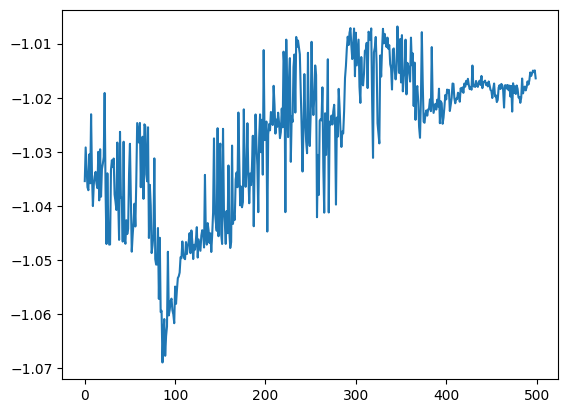

In [336]:
plt.plot(errs)

In [390]:
np.argmin(errs)

86

In [272]:
mat = scipy.io.loadmat(ants_reg_mapping(test1,test2)[0])
np.vstack((mat['AffineTransform_float_3_3'].reshape(3,4,order='F'),np.array([0,0,0,1])))

array([[  1.        ,   0.        ,   0.        ,  -0.73694587],
       [  0.        ,   1.        ,   0.        ,  -0.43105316],
       [  0.        ,   0.        ,   1.        , -21.25942993],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

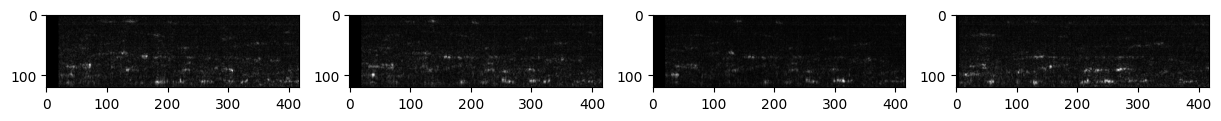

In [273]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
axes = axes.flatten()
axes[0].imshow(test1[0],cmap='gray')
axes[1].imshow(test1[2],cmap='gray')
axes[2].imshow(test1[4],cmap='gray')
axes[3].imshow(test2[2],cmap='gray')

In [ ]:
plt.imshow(test1[2],cmap='gray')

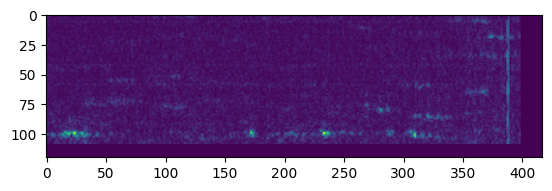

In [258]:
plt.imshow((min_max(scp.affine_transform(test2,matrix=np.array([[1,0,0,-1.37],[0,1,0,11],[0,0,1,18],[0,0,0,1]],dtype=np.float32)))*255).astype(np.uint8)[3])

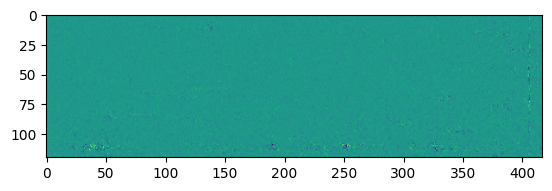

In [242]:
plt.imshow(scp.affine_transform(test2,matrix=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],dtype=np.float32))[1])

In [219]:
np.unique(warp(test2,AffineTransform(matrix = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]), dimensionality=3)))

array([0.], dtype=float32)

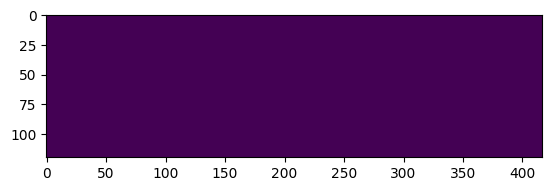

In [214]:
plt.imshow(warp(test2,AffineTransform(matrix = np.array([[1,0,0],[0,1,10],[0,0,1]]), dimensionality=3))[2])

In [133]:
AffineTransform(matrix = np.vstack((mat['AffineTransform_float_3_3'].reshape(3,4,order='F'),np.array([0,0,0,1]))), dimensionality=3)

<AffineTransform(matrix=
    [[ 1.        ,  0.        ,  0.        , -1.37157178],
     [ 0.        ,  1.        ,  0.        , 11.38686371],
     [ 0.        ,  0.        ,  1.        , 18.05326843],
     [ 0.        ,  0.        ,  0.        ,  1.        ]]) at 0x1c17c0fd0>

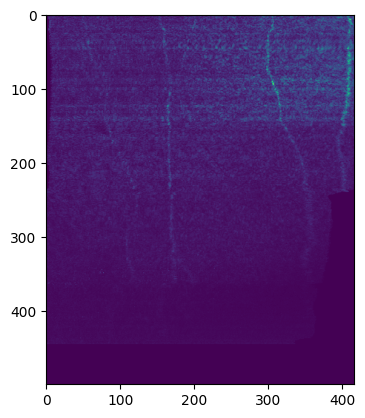

In [ ]:
plt.imshow(reg_nerve_images[7])

In [55]:
reg_nerve_images[0].shape

(500, 417)

In [441]:
from scipy import optimize

print(optimize.differential_evolution(shift_ncc, bounds = ([[-5,5]]),args = (a,b))['x'])
print(optimize.dual_annealing(shift_ncc, bounds = ([[-5,5]]),args = (a,b))['x'])
print(optimize.shgo(shift_ncc, bounds = ([[-5,5]]),args = (a,b))['x'])

[-2.78842527]
[-2.93492182]
[-5.]


In [466]:
def shift_ncc(shif,x,y):
    # tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = scp.shift(y,shift=(shif[0]),order=0)

    # warped = warp(y, tform,order=3)
    # return -ncc(x,warped)
    # print(1-ncc(x,warped),shif[0])
    return 1-ncc(x,warped)

In [420]:
a = np.array([1,1,1,0,0,0])
b = np.array([0,0,0,1,1,1])

In [417]:
shift_ncc([100],a,b)

array([1.])

In [404]:
# shift_ncc(0,reg_nerve_images[9][10],reg_nerve_images[8][10])
move = minz(method='powell',fun = shift_ncc,x0 =(0),
                    args = (reg_nerve_images[9][10],reg_nerve_images[8][10]))['x']

move

array([3.51023034])

In [456]:
l_bound, r_bound = -len(reg_nerve_images[0][0])*0.75, len(reg_nerve_images[0][0])*0.75
l_bound,r_bound

(-312.75, 312.75)

In [473]:
nn = []
for row in tqdm(range(0,reg_nerve_images[0].shape[0],10)):
    move = optimize.dual_annealing(shift_ncc, bounds = ([[-100,100]]),args = (reg_nerve_images[9][row:row+10],reg_nerve_images[8][row:row+10]))['x']
    # nn.append(phase_cross_correlation(reg_nerve_images[9][row],reg_nerve_images[8][row])[0])
    nn.append(move)

100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


In [468]:
# a = np.array([0,0,0,1,1,1])
# scp.shift(a,shift=(1))

In [474]:
nn

[array([0.37572575]),
 array([-0.6882527]),
 array([-0.02768134]),
 array([0.65110554]),
 array([0.46174949]),
 array([0.82778042]),
 array([-0.57253681]),
 array([0.38661258]),
 array([0.24182085]),
 array([-0.48335113]),
 array([-0.07811651]),
 array([-0.73914076]),
 array([-0.02460777]),
 array([-0.79096112]),
 array([-0.37076185]),
 array([-0.61232288]),
 array([-0.51939238]),
 array([-0.78346723]),
 array([-0.63653122]),
 array([0.88389108]),
 array([-0.6053168]),
 array([-0.7879079]),
 array([-0.57258504]),
 array([0.88637407]),
 array([-0.75921054]),
 array([0.34041394]),
 array([0.13403926]),
 array([-0.9040305]),
 array([-0.64915135]),
 array([0.36412154]),
 array([-0.98165895]),
 array([-0.63540671]),
 array([-0.5491979]),
 array([-0.85703927]),
 array([-0.81130323]),
 array([-0.65272877]),
 array([-0.67518234]),
 array([-0.5325552]),
 array([-0.76072938]),
 array([-0.52067234]),
 array([-0.63347297]),
 array([-0.49370706]),
 array([-0.01060836]),
 array([79.38387602]),
 arra

In [494]:
temp_nerve = reg_nerve_images[8].copy()
# j = 0
# for i in range(0,len(nn),10):
#     temp_nerve[i:i+10] = scp.shift(temp_nerve[i:i+10],shift=(nn[j][0]),order = 5)
#     j+=1

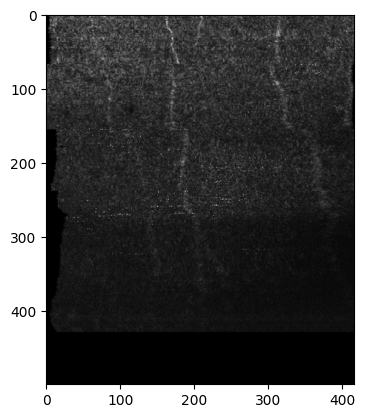

In [495]:
plt.imshow(temp_nerve,cmap='gray')

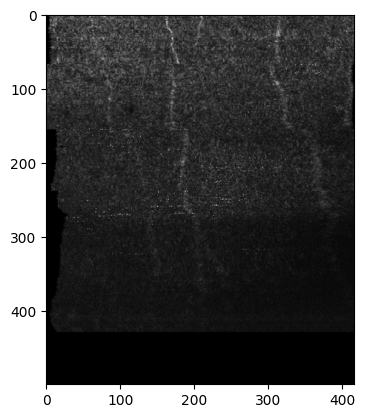

In [173]:
plt.imshow(reg_nerve_images[8],cmap='gray')

In [171]:
# for i in range(1,len(all_reg)-1):
#     print(all_reg[i-1],all_reg[i],all_reg[i+1])
#     print(phase_cross_correlation(np.mean(datas[all_reg[i]].transpose(1,0,2)[1428:1436],axis=0)
#                                 ,np.mean(datas[all_reg[i-1]].transpose(1,0,2)[1428:1436],axis=0),normalization=None,upsample_factor = 20)[0][1],
#             phase_cross_correlation(np.mean(datas[all_reg[i]].transpose(1,0,2)[1428:1436],axis=0)
#                                 ,np.mean(datas[all_reg[i+1]].transpose(1,0,2)[1428:1436],axis=0),normalization=None,upsample_factor = 20)[0][1])

In [128]:
a = scp.sobel(min_max(np.mean(datas['scan21'].transpose(1,0,2)[1428:1436],axis=0)),1)
b = scp.sobel(min_max(np.mean(datas['scan22'].transpose(1,0,2)[1428:1436],axis=0)),1)

In [129]:
phase_cross_correlation(a,b,normalization=None)

(array([-33., -33.], dtype=float32), 0.9973159065333891, -2.4975055e-08)

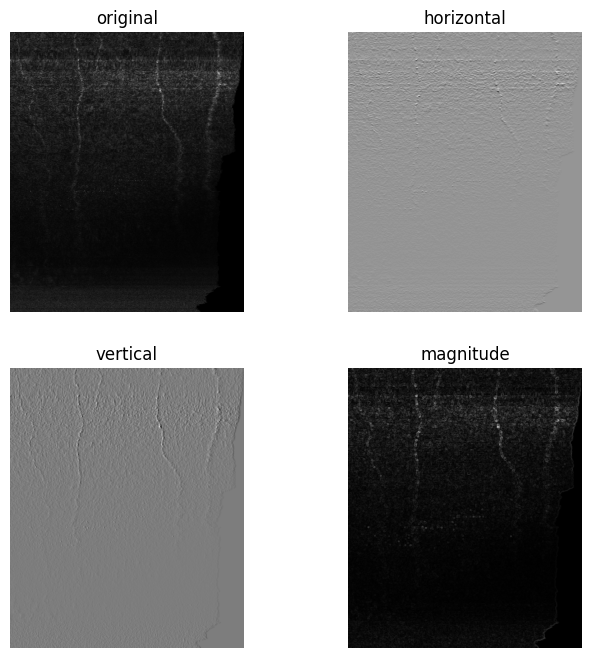

In [110]:
from scipy import ndimage, datasets
import matplotlib.pyplot as plt
import numpy as np
ascent = min_max(np.mean(datas['scan21'].transpose(1,0,2)[1428:1436],axis=0))
sobel_h = ndimage.sobel(ascent, 0)  # horizontal gradient
sobel_v = scp.sobel(ascent, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
magnitude *= 255.0 / np.max(magnitude)  # normalization
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.gray()  # show the filtered result in grayscale
axs[0, 0].imshow(ascent)
axs[0, 1].imshow(sobel_h)
axs[1, 0].imshow(sobel_v)
axs[1, 1].imshow(magnitude)
titles = ["original", "horizontal", "vertical", "magnitude"]
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.axis("off")
plt.show()

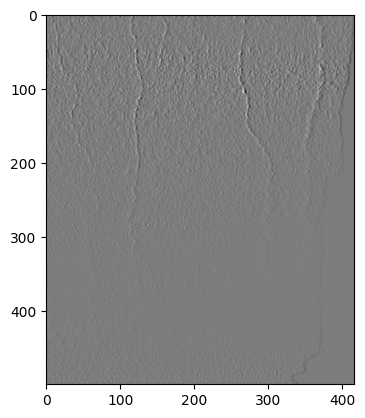

In [109]:
plt.imshow(min_max(sobel_v))